# WRONG. bad methods

In [14]:
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
from ue.uexp.models.util import *
import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

## Data + preprocessing

In [35]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2021-12-15"
end_date = "2021-12-31"
time_interval = "1m"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

In [36]:
df.head()

,time,open,high,low,close,volume,adj_close,tic
0,2021-12-15 00:00:00,48120.88,48157.41,48120.87,48136.00,14.51234,48136.00,BTCUSDT
1,2021-12-15 00:01:00,48136.00,48145.09,48112.28,48129.20,9.31538,48129.20,BTCUSDT
2,2021-12-15 00:02:00,48129.20,48185.21,48126.67,48184.64,12.80545,48184.64,BTCUSDT
3,2021-12-15 00:03:00,48184.64,48186.88,48173.02,48178.98,6.95185,48178.98,BTCUSDT
4,2021-12-15 00:04:00,48178.99,48189.66,48156.08,48187.29,17.31493,48187.29,BTCUSDT


In [37]:
# for 1min data
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.drop(["adj_close", "tic"], axis=1, inplace=True)
df.columns = ["Open","High","Low","Close","Volume"]

In [38]:
# #for 1s data
#df.drop(["tic"], axis=1, inplace=True)
#df.columns = ["Open","High","Low","Close","Volume"]

In [39]:
df.head()

,Open,High,Low,Close,Volume
time,,,,,
2021-12-15 00:00:00,48120.88,48157.41,48120.87,48136.00,14.51234
2021-12-15 00:01:00,48136.00,48145.09,48112.28,48129.20,9.31538
2021-12-15 00:02:00,48129.20,48185.21,48126.67,48184.64,12.80545
2021-12-15 00:03:00,48184.64,48186.88,48173.02,48178.98,6.95185
2021-12-15 00:04:00,48178.99,48189.66,48156.08,48187.29,17.31493
...,...,...,...,...,...
2021-12-30 23:55:00,47321.60,47345.38,47321.59,47325.32,7.18740
2021-12-30 23:56:00,47325.32,47325.32,47297.49,47311.06,6.26538
2021-12-30 23:57:00,47311.06,47329.43,47303.92,47312.89,4.82009


In [40]:
df_feats0 = gen_feats0(df)
df_feats0.head()

,Open,High,Low,Close,Volume,spread,upper_Shadow,lower_Shadow,trade
time,,,,,,,,,
2021-12-15 00:00:00,48120.88,48157.41,48120.87,48136.00,14.51234,36.54,21.41,0.01,15.12
2021-12-15 00:01:00,48136.00,48145.09,48112.28,48129.20,9.31538,32.81,9.09,16.92,-6.80
2021-12-15 00:02:00,48129.20,48185.21,48126.67,48184.64,12.80545,58.54,0.57,2.53,55.44
2021-12-15 00:03:00,48184.64,48186.88,48173.02,48178.98,6.95185,13.86,2.24,5.96,-5.66
2021-12-15 00:04:00,48178.99,48189.66,48156.08,48187.29,17.31493,33.58,2.37,22.91,8.30
...,...,...,...,...,...,...,...,...,...
2021-12-30 23:55:00,47321.60,47345.38,47321.59,47325.32,7.18740,23.79,20.06,0.01,3.72
2021-12-30 23:56:00,47325.32,47325.32,47297.49,47311.06,6.26538,27.83,0.00,13.57,-14.26
2021-12-30 23:57:00,47311.06,47329.43,47303.92,47312.89,4.82009,25.51,16.54,7.14,1.83


In [6]:
# df_feats2 = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume")
# df_feats2.head()

## Model Parameters

In [41]:
HORIZON = 1
WINDOW = 30

## Make Windowed dataset

In [42]:
# Make a copy of the Bitcoin historical data with block reward feature
df0 = df_feats0.copy()

,Open,High,Low,Close,Volume,spread,upper_Shadow,lower_Shadow,trade
time,,,,,,,,,
2021-12-15 00:00:00,48120.88,48157.41,48120.87,48136.00,14.51234,36.54,21.41,0.01,15.12
2021-12-15 00:01:00,48136.00,48145.09,48112.28,48129.20,9.31538,32.81,9.09,16.92,-6.80
2021-12-15 00:02:00,48129.20,48185.21,48126.67,48184.64,12.80545,58.54,0.57,2.53,55.44
2021-12-15 00:03:00,48184.64,48186.88,48173.02,48178.98,6.95185,13.86,2.24,5.96,-5.66
2021-12-15 00:04:00,48178.99,48189.66,48156.08,48187.29,17.31493,33.58,2.37,22.91,8.30


In [43]:
# Add windowed columns
for i in range(WINDOW): # Shift values for each step in WINDOW_SIZE
  df0[f"Price+{i+1}"] = df0["Close"].shift(periods=i+1)
df0.head(5)

,Open,High,Low,Close,Volume,spread,upper_Shadow,lower_Shadow,trade,Price+1,...,Price+21,Price+22,Price+23,Price+24,Price+25,Price+26,Price+27,Price+28,Price+29,Price+30
time,,,,,,,,,,,,,,,,,,,,,
2021-12-15 00:00:00,48120.88,48157.41,48120.87,48136.00,14.51234,36.54,21.41,0.01,15.12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-15 00:01:00,48136.00,48145.09,48112.28,48129.20,9.31538,32.81,9.09,16.92,-6.80,48136.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-15 00:02:00,48129.20,48185.21,48126.67,48184.64,12.80545,58.54,0.57,2.53,55.44,48129.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-15 00:03:00,48184.64,48186.88,48173.02,48178.98,6.95185,13.86,2.24,5.96,-5.66,48184.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-15 00:04:00,48178.99,48189.66,48156.08,48187.29,17.31493,33.58,2.37,22.91,8.30,48178.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
print("using [price_0, ..., price_29, volume, spread, log_price_change] to predict -> price_30")

using [price_0, ..., price_29, volume, spread, log_price_change] to predict -> price_30


In [45]:
X = df0.dropna().drop(["Close","Open","High","Low"], axis=1).astype(np.float32) 
X.head()

,Volume,spread,upper_Shadow,lower_Shadow,trade,Price+1,Price+2,Price+3,Price+4,Price+5,...,Price+21,Price+22,Price+23,Price+24,Price+25,Price+26,Price+27,Price+28,Price+29,Price+30
time,,,,,,,,,,,,,,,,,,,,,
2021-12-15 00:30:00,34.054062,74.919998,13.330000,34.93,26.660000,48260.019531,48250.000000,48254.968750,48275.960938,48296.648438,...,48156.441406,48187.351562,48173.691406,48199.980469,48176.160156,48187.289062,48178.980469,48184.640625,48129.199219,48136.000000
2021-12-15 00:31:00,22.972000,61.430000,37.169998,7.59,-16.670000,48286.671875,48260.019531,48250.000000,48254.968750,48275.960938,...,48143.980469,48156.441406,48187.351562,48173.691406,48199.980469,48176.160156,48187.289062,48178.980469,48184.640625,48129.199219
2021-12-15 00:32:00,18.178961,69.349998,7.990000,12.57,-48.790001,48270.011719,48286.671875,48260.019531,48250.000000,48254.968750,...,48100.468750,48143.980469,48156.441406,48187.351562,48173.691406,48199.980469,48176.160156,48187.289062,48178.980469,48184.640625
2021-12-15 00:33:00,9.085590,38.880001,0.730000,12.77,-25.379999,48221.218750,48270.011719,48286.671875,48260.019531,48250.000000,...,48085.648438,48100.468750,48143.980469,48156.441406,48187.351562,48173.691406,48199.980469,48176.160156,48187.289062,48178.980469
2021-12-15 00:34:00,13.541770,58.130001,4.000000,16.32,-37.810001,48195.828125,48221.218750,48270.011719,48286.671875,48260.019531,...,48122.980469,48085.648438,48100.468750,48143.980469,48156.441406,48187.351562,48173.691406,48199.980469,48176.160156,48187.289062


In [46]:
y = df0.dropna()["Close"].astype(np.float32)
y.head()

time
2021-12-15 00:30:00    48286.671875
2021-12-15 00:31:00    48270.011719
2021-12-15 00:32:00    48221.218750
2021-12-15 00:33:00    48195.828125
2021-12-15 00:34:00    48158.019531
Name: Close, dtype: float32

### Train test split (80%)

In [47]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(8912, 8912, 2229, 2229)

## Model building and fitting

In [48]:
# Make multivariate time series model
model_dense_multivariate = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_dense_multivariate")

# Compile
model_dense_multivariate.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mean_squared_error','mean_absolute_percentage_error', 'mean_absolute_error']
)

# Fit
model_dense_multivariate.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_dense_multivariate.name)])

2022-02-03 15:21:13.070797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 15:21:13.078683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/nvidia:/home/m73/.mujoco/mujoco210/bin
2022-02-03 15:21:13.079769: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-03 15:21:13.080352: I tensorflow/core/platform/cpu_feature_guard.cc:151] This Ten

INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_dense_

## Evaluating model on test data

In [52]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_dense_multivariate")
model_6.evaluate(X_test, y_test)

70/70 [==============================] - 0s 443us/step - loss: 96.9928 - mean_squared_error: 27684.7695 - mean_absolute_percentage_error: 0.2028 - mean_absolute_error: 96.9928


[96.99279022216797, 27684.76953125, 0.2027556449174881, 96.99279022216797]

## Plotting y_true and y_pred

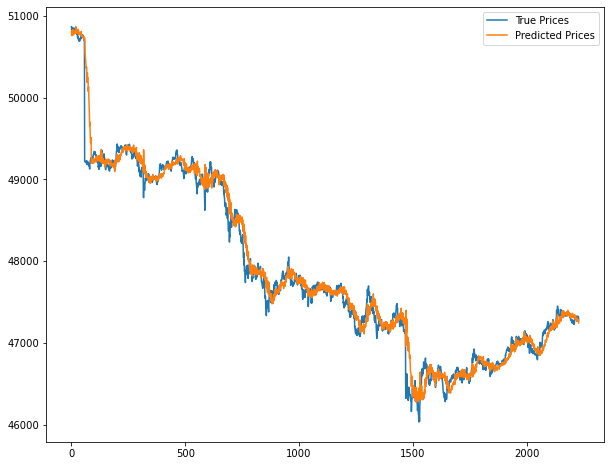

In [58]:
plt.figure(figsize=(10, 8))
plt.plot(y_test.to_numpy(), label = "True Prices")
plt.plot(y_pred, label = "Predicted Prices")
plt.legend()
plt.show()